In [1]:
!pip install tensorflow-datasets
!git clone https://github.com/beringresearch/lrfinder/


Cloning into 'lrfinder'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 54 (delta 12), reused 52 (delta 10), pack-reused 0
Unpacking objects: 100% (54/54), done.


https://github.com/beringresearch/lrfinder

In [2]:
!cd lrfinder && python3 -m pip install .

Processing /content/lrfinder
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for lrfinder: filename=lrfinder-0.1-py3-none-any.whl size=2487 sha256=dade0765647a8e2c88b1b628b69a1d4aa08a00490e5bdbef649ca5a5a29baa4d
  Stored in directory: /tmp/pip-ephem-wheel-cache-sh72sx8o/wheels/86/9d/6e/77716e502c767656047e5d92c0e2daa34b83316533a1b339bc
Successfully built lrfinder


In [3]:
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import numpy as np
from lrfinder import LRFinder

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label



In [6]:
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

https://datascience.stackexchange.com/questions/46124/what-do-compile-fit-and-predict-do-in-keras-sequential-models

In [7]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)


In [20]:
BATCH = 128

lr_finder = LRFinder(model)
STEPS_PER_EPOCH = np.ceil(len(ds_train) / BATCH)
lr_finder.find(ds_train, start_lr=1e-6, end_lr=1, epochs=20,
               steps_per_epoch=STEPS_PER_EPOCH)
learning_rates = lr_finder.get_learning_rates()
losses = lr_finder.get_losses()


Epoch 1/20
469/469 [==============================] - 0s 680us/step - loss: 17.5841 - sparse_categorical_accuracy: 0.4058


https://arxiv.org/abs/1506.01186
https://github.com/surmenok/keras_lr_finder

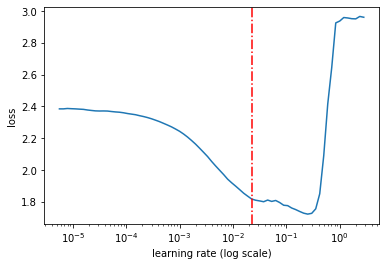

In [21]:
def plot_loss(learning_rates, losses, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
    f, ax = plt.subplots()
    ax.set_ylabel("loss")
    ax.set_xlabel("learning rate (log scale)")
    ax.plot(learning_rates[n_skip_beginning:-n_skip_end],
            losses[n_skip_beginning:-n_skip_end])
    ax.set_xscale(x_scale)
    return(ax)

axs = plot_loss(learning_rates,losses)
axs.axvline(x=lr_finder.get_best_lr(sma=20), c='r', linestyle='-.')


In [22]:
best_lr = lr_finder.get_best_lr(sma=20)
K.set_value(model.optimizer.lr, best_lr)
print(K.eval(model.optimizer.lr))


0.022387208


# Day 5 task

- Apply Earlystopping for the model we trained in last session with monitor validation loss and patience 3



In [33]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop_callback = EarlyStopping(
  monitor='val_loss', min_delta=0.0001, patience=3)


In [34]:
num_epochs=20

In [35]:
model.fit(ds_train, epochs=num_epochs, validation_data=ds_test, callbacks=[earlystop_callback])
model.evaluate(ds_test)

Epoch 1/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1185 - sparse_categorical_accuracy: 0.9707 - val_loss: 0.2829 - val_sparse_categorical_accuracy: 0.9495
Epoch 2/20
469/469 [==============================] - 2s 3ms/step - loss: 0.1216 - sparse_categorical_accuracy: 0.9714 - val_loss: 0.2676 - val_sparse_categorical_accuracy: 0.9545
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1212 - sparse_categorical_accuracy: 0.9721 - val_loss: 0.2719 - val_sparse_categorical_accuracy: 0.9568
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1186 - sparse_categorical_accuracy: 0.9733 - val_loss: 0.2543 - val_sparse_categorical_accuracy: 0.9616
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1162 - sparse_categorical_accuracy: 0.9743 - val_loss: 0.3532 - val_sparse_categorical_accuracy: 0.9549
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1277 - sparse_categorica

[0.31707483530044556, 0.9606999754905701]

- https://github.com/keras-team/keras/issues/9672
- https://stackoverflow.com/questions/34518656/how-to-interpret-loss-and-accuracy-for-a-machine-learning-model
- https://stackoverflow.com/questions/43589842/test-score-vs-test-accuracy-when-evaluating-model-using-keras
- for score and accuracy in the array return of model evaluate

In [36]:
model.evaluate(ds_test)

79/79 [==============================] - 0s 2ms/step - loss: 0.3171 - sparse_categorical_accuracy: 0.9607


[0.31707483530044556, 0.9606999754905701]

In [28]:
print(len(ds_test))

79


In [29]:
print(len(ds_train))

469
